This notebook was made to try to evaluate the detectron2 model locally. This has not worked as it needs a GPU. In addition, given the non standard output which does not correspond to the exact original COCO output, a more manual evaluation was necessary. It should be noted that by reduced set (wether train or test) refers to the absence of the sigil class in the segmentation procedure.

In [14]:
import pickle
import torch, torchvision
import detectron2
# setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from cv2 import imshow
import argparse
import glob
import multiprocessing as mp
import time
import cv2
import tqdm
from PIL import Image
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.detection_utils import read_image
from detectron2.utils.logger import setup_logger
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data.datasets import register_coco_instances
import matplotlib.pyplot as plt
# setup_logger()

from DetectronUtils import VisualizationDemo
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
import pytesseract


In [2]:
def get_patents_dataset_dicts(d):
    """
    function to get a dataset of patents for segmentation
    Args:
    d - a string which can be:
        train - for the full train set
        train_reduced - for the reduced train set
        test - for the full test set
        test_reduced - for the reduced test set
    Returns:
    the dataset in the form of a dictionary
    """
    if d == 'train':
        with open('/Volumes/Non-Backup_Files/GB-patents/json/local/dataset/train_data.json') as json_file:
            coco_data_train = json.load(json_file)
        return coco_data_train
    elif d == 'train_reduced':
        with open('/Volumes/Non-Backup_Files/GB-patents/json/local/dataset/train_data_reduced.json') as json_file:
            coco_data_reduced_train = json.load(json_file)
        return coco_data_reduced_train 
    elif d == 'test_reduced':
        with open('/Volumes/Non-Backup_Files/GB-patents/json/local/dataset/test_data_reduced.json') as json_file:
            coco_data_reduced_test = json.load(json_file)
        return coco_data_reduced_test 
    else:
        with open('/Volumes/Non-Backup_Files/GB-patents/json/local/dataset/test_data.json') as json_file:
            coco_data_test = json.load(json_file)
        return coco_data_test   

In [3]:
def get_patents_coco_path(d):
    """
    function to get a the path of a dataset of patents for segmentation (in coco format)
    Args:
    d - a string which can be:
        train - for the full train set
        train_reduced - for the reduced train set
        test - for the full test set
        test_reduced - for the reduced test set
    Returns:
    the path to the selected coco dataset
    """
    if d == 'train':
        return '/Volumes/Non-Backup_Files/GB-patents/json/local/coco/train_data.json'
    elif d == 'train_reduced':
        return '/Volumes/Non-Backup_Files/GB-patents/json/local/coco/train_data_reduced.json' 
    elif d == 'test_reduced':
        return '/Volumes/Non-Backup_Files/GB-patents/json/local/coco/test_data_reduced.json'
    else:
        return '/Volumes/Non-Backup_Files/GB-patents/json/local/coco/test_data.json'   

In [4]:
#register all coco datasets
from detectron2.data.datasets import register_coco_instances
for d in ['train', 'test', 'train_reduced', 'test_reduced']:
    register_coco_instances("patents_coco_" + d, {}, get_patents_coco_path(d), "./data_for_model")

In [5]:
#register all datasets
for d in ['train', 'test']:
    DatasetCatalog.register("patents_dataset_" + d,lambda d=d: get_patents_dataset_dicts(d))
    MetadataCatalog.get("patents_dataset_" + d).set(thing_classes=['text', 'title', 'list', 'table', 'figure', 'sigil'])
patents_metadata = MetadataCatalog.get("patents_dataset_train")
for d in ['train_reduced', 'test_reduced']:
    DatasetCatalog.register("patents_dataset_" + d,lambda d=d: get_patents_dataset_dicts(d))
    MetadataCatalog.get("patents_dataset_" + d).set(thing_classes=['text', 'title', 'list', 'table', 'figure'])
patents_reduced_metadata = MetadataCatalog.get("patents_dataset_train_reduced")

In [26]:
#set up configuration and build model
cfg = get_cfg()
cfg.merge_from_file('/Users/andrealphonse/Documents/UniStuff/MA/MA3/Classes/Patent Project/PubLayNet/detectron2/detectron_config/DLA_mask_rcnn_R_101_FPN_3x.yaml')
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.5
cfg.MODEL.DEVICE = 'cpu'
cfg.DATASETS.TEST = ("patents_coco_test", )
cfg.MODEL.WEIGHTS = '/Users/andrealphonse/Documents/UniStuff/MA/MA3/Classes/Patent Project/PubLayNet/finetuned_detectron2/no_sigil/resnet101/model_final.pth'
cfg.freeze()
model = build_model(cfg)
DetectionCheckpointer(model).load('/Users/andrealphonse/Documents/UniStuff/MA/MA3/Classes/Patent Project/PubLayNet/finetuned_detectron2/no_sigil/resnet50/model_final.pth')
# demo = VisualizationDemo(cfg)
# predictions, visualized_output = demo.run_on_image(img)
# visualized_output.save('Detectron2LayoutAnalysisOutput/3408_00000002')

Config '/Users/andrealphonse/Documents/UniStuff/MA/MA3/Classes/Patent Project/PubLayNet/detectron2/detectron_config/DLA_mask_rcnn_R_101_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


{'optimizer': {'state': {0: {'momentum_buffer': tensor([[[[-2.7609e-04]],
    
             [[-5.1417e-04]],
    
             [[-6.7714e-05]],
    
             ...,
    
             [[-1.4896e-04]],
    
             [[-3.5563e-04]],
    
             [[-4.4273e-04]]],
    
    
            [[[ 4.3996e-04]],
    
             [[ 1.2098e-03]],
    
             [[ 3.5448e-04]],
    
             ...,
    
             [[ 1.5452e-04]],
    
             [[ 7.3990e-04]],
    
             [[ 3.8605e-04]]],
    
    
            [[[ 2.8189e-05]],
    
             [[ 1.0585e-04]],
    
             [[-4.9108e-04]],
    
             ...,
    
             [[-1.1181e-04]],
    
             [[-3.3179e-04]],
    
             [[ 1.3153e-04]]],
    
    
            ...,
    
    
            [[[-3.8503e-04]],
    
             [[-1.6237e-03]],
    
             [[-6.1168e-04]],
    
             ...,
    
             [[-3.3197e-04]],
    
             [[-5.7634e-04]],
    
             [

In [27]:
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [22]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_patents_dataset_dicts('test')

In [10]:
dataset_dicts

[{'annotations': [{'segmentation': [[142,
      292,
      1216,
      292,
      1216,
      1988,
      142,
      1988,
      142,
      292]],
    'bbox': [142.0, 292.0, 1216.0, 1988.0],
    'category_id': 0,
    'bbox_mode': 0},
   {'segmentation': [[192, 138, 1177, 138, 1177, 269, 192, 269, 192, 138]],
    'bbox': [192.0, 138.0, 1177.0, 269.0],
    'category_id': 1,
    'bbox_mode': 0}],
  'file_name': '/Volumes/Non-Backup_Files/GB-patents/data_for_model/GB187303488A/3.png',
  'image_id': 3766,
  'width': 1420,
  'height': 2116},
 {'annotations': [{'segmentation': [[201,
      259,
      1280,
      259,
      1280,
      1935,
      201,
      1935,
      201,
      259]],
    'bbox': [201.0, 259.0, 1280.0, 1935.0],
    'category_id': 0,
    'bbox_mode': 0},
   {'segmentation': [[318, 135, 1180, 135, 1180, 246, 318, 246, 318, 135]],
    'bbox': [318.0, 135.0, 1180.0, 246.0],
    'category_id': 1,
    'bbox_mode': 0}],
  'file_name': '/Volumes/Non-Backup_Files/GB-patents/data_for

{'instances': Instances(num_instances=1, image_height=2095, image_width=2565, fields=[pred_boxes: Boxes(tensor([[1104.5820,   60.8177, 2414.0024, 2020.9281]])), scores: tensor([0.9938]), pred_classes: tensor([4]), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])])}


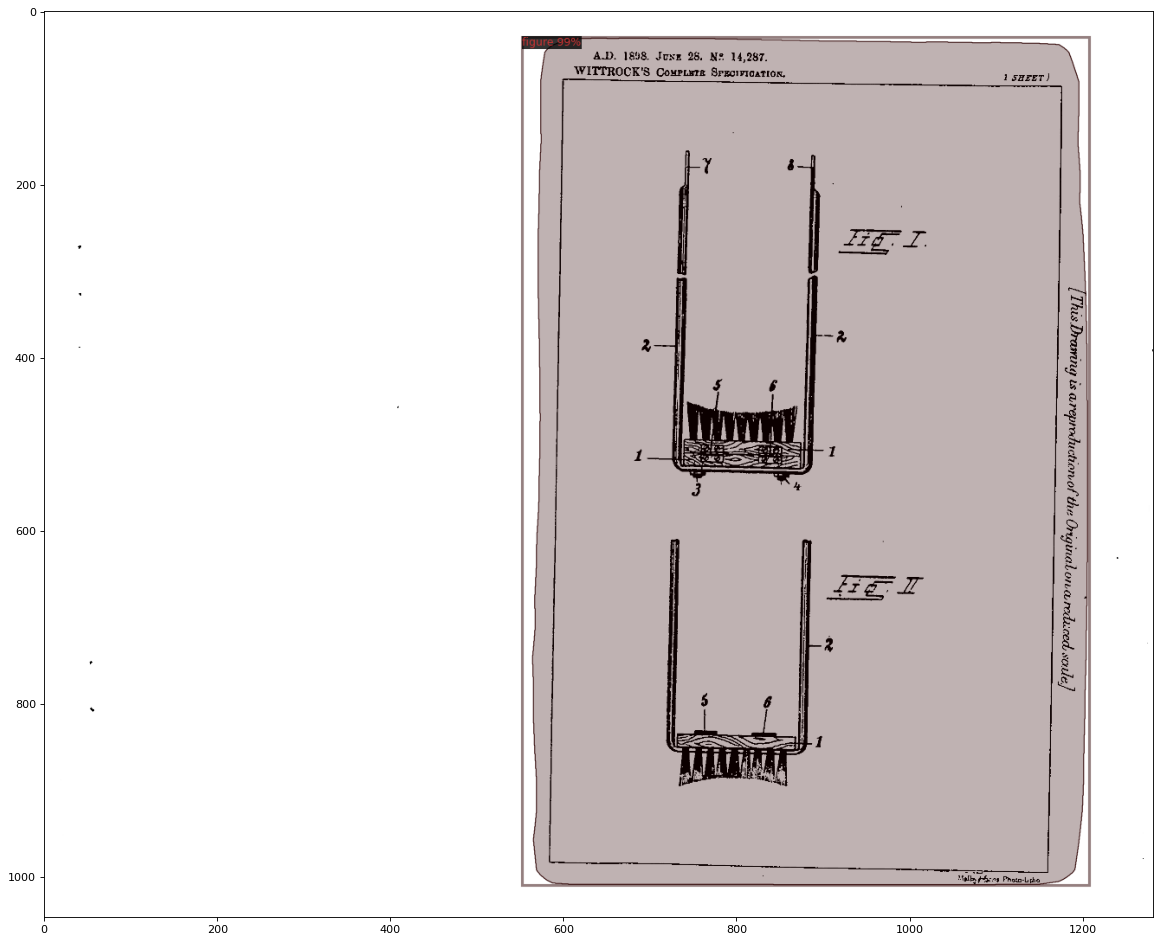

In [28]:
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=patents_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    print(outputs)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(num=None, figsize=(18, 15), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(out.get_image()[:, :, ::-1])
#     cv2_imshow(out.get_image()[:, :, ::-1])

In [9]:
#try evalation
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("patents_coco_test", ("bbox"), False, output_dir="./eval")
val_loader = build_detection_test_loader(cfg, "patents_dataset_test")
print(inference_on_dataset(model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`
# trainer.test(cfg, build_model(cfg), [evaluator])

/Users/andrealphonse/anaconda/envs/patentproj/lib/python3.6/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


Loading and preparing results...


AssertionError: Results do not correspond to current coco set